# Detection time comparisons

Use different methods to estimate the time-to-detection of Arctic climate change. We will ignore measurement error for now.

__Methods:__

- Weatherhead et al. (1998)
- Leroy et al. (2008)
- Naive Large-Ensemble method (intended to be analogous to the SNR methods of Weatherhead and Leroy)
- Large-Ensemble method (intended to be closer to the advanced statistical methods of Barnhart et al. (2016))

## Description of Methods

#### Weatherhead et al. (1998)

$$ n^* \approx \left[ \frac{3.3 \sigma_{\epsilon}}{|\omega_0|(1-\phi)} \right] ^{2/3} = \left[ \frac{3.3 \sigma_{N}}{|\omega_0|} \sqrt{\frac{1+\phi}{1 - \phi}} \right] ^{2/3}, $$

where $n^*$ is the number of years needed to dect a real trend of magnitude $|\omega_0|$ with probability $0.90$, $\phi$ is the lag-1 autocorrelation, $\sigma_{\epsilon}$ is the standard deviation of random noise, and $\sigma_{N}$ is the standard deviation of the climate variable after a linear trend is removed (the measured noise).

_This method uses is the first iteration of the signal-to-noise method, where time-to-detection is determined by estimating the uncertainty in a linear regression fit and the degree of autocorrelation is estimated entirely from the lag-1 autocorrelation.__

#### Leroy et al. (2008)

After ignoring measurement error, we have:  

$$ \Delta t = \left[ \frac{12s^2}{m_{est}^2} \sigma_{var}^2 \tau_{var} \right]^{1/3}, $$

where $\Delta t$ is the number of years needed to detect a real trend of magnitude $m_{est}$, $\tau_{var}$ is the correlation time for natural variability, and $\sigma_{var}$ is the standard deviation of natural variability. The meaning of $\tau_{var}$ is confusing, but it can be thought of as the number of timesteps until the correlation function reaches zero/the natural noise. This is complicated by correlation functions with different shapes and definitions of noise. Leroy et al. define the correlation time as the sum of the natural variability autocorrelation function over all lags $\mu$:

$$ \tau_{var} = dt \sum_{\mu=-\infty}^{\infty} Corr(var) $$

For the 95% confidence interval, the signal-to-noise ratio $s$ is taken to be $s=2$ (5% of possible scenarios lie outside of two standard deviations on either side of a normal distribution).

I will put confidence intervals on Leroy's $\Delta t$ by propagating an error in the forced response $\delta m_{est}$:  

$$ \delta \Delta t = \frac{\partial \Delta t}{\partial m_{est}} \delta m_{est} $$

$$ \frac{\partial \Delta t}{\partial m_{est}} = \frac{-2}{3m_{est}} \left[ \frac{12s^2}{m_{est}^2} \sigma_{var}^2 \tau_{var} \right]^{1/3} = \frac{-2}{3m_{est}} \Delta t $$

$$ \delta \Delta t = \frac{-2}{3m_{est}} \Delta t \delta m_{est} $$

We can rewrite this expression in terms of the fractional uncertainties of the forced response and the detection time:

$$ \frac{\delta \Delta t}{\Delta t} = \frac{2}{3} \left( \frac{\delta m_{est}}{m_{est}} \right), $$

so the fractional uncertainty in the forced response transfers to the detection time after applying a small scaling term. We now ask, what is our uncertainty in the forced response? A large ensemble shows uncertainty in a forced response, but there is also uncertainty in the forced response because it depends on the climate mean state when measurements begin, and uncertainty due to model physics (not considered here). Can we just calculate these terms and add them in quadrature:

$$ \delta m_{est}^2 = \delta m_{est,lens}^2 + \delta m_{est,mean-state}^2 + \delta m_{est,physics}^2 $$

I can estimate $\delta m_{est,lens}$ by sampling across ensemble members and $\delta m_{est,mean-state}$ by sampling the forced response across different start years. Are these values correlated? i.e. Are these estimates duplicative because the difference in mean-state at the start of the sampling period gives rise to the spread in the large-ensemble?

#### Naive Large-Ensemble Method

Here, I intend to produce time-to-detection estimates using the output from the CESM1 and CESM2 Large Ensemble datasets that are somewhat analogous to the signal-to-noise methods employed previously. These methods define time-to-detection as when the mean forced response exceeds the natural climate variability at 95% confidence. I can do the same by creating 95% confidence intervals (2 std. devs. to be comparable with Weatherhead and Leroy) and comparing them to a linear trend calculated from the large ensemble forced response.

I expect these results to be similar to those estimated from the Leroy method.

#### Nuanced Large-Ensemble Method (simplified Barnhart)

Here, I intend to produce time-to-detection estimates using the output from the CESM1 and CESM2 Large Ensemble datasets that account for variability in the forced response. Whereas previous methods treat the forced response as a single value (the mean forced response), here I will place confidence intervals on the forced response to answer a more useful question: "How many years do we need to measure to be 95% confident of measuring a trend that exceeds natural climate variability?"

I expect these results to predict longer detection times than the previous three methods employed.

## Load Data

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    np, xr, plt, sns, os, 
    datetime, gridspec, 
    Iterable, cmaps, glob, copy,
    dask,pd
    )

from functions import (
    add_weights,
    to_png, stats, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load pre-processed timeseries

In [2]:
tseries_savedir = '/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticTimeSeries/'

cesm1_pic_ds = xr.open_dataset('%s/CESM1_PIControl_ArcticTimeSeries.nc' % tseries_savedir)
cesm1_forcedresponse_ds = xr.open_dataset('%s/CESM1_ForcedResponse_ArcticTimeSeries.nc' % tseries_savedir)
cesm1_ensresponse_ds = xr.open_dataset('%s/CESM1_RCP8.5Members_ArcticTimeSeries.nc' % tseries_savedir)

Get the variables.

In [3]:
ens_vars = list(cesm1_pic_ds.data_vars)

## Method Implementation

#### Weatherhead et al. (1998)

$$ n^* \approx \left[ \frac{3.3 \sigma_{\epsilon}}{|\omega_0|(1-\phi)} \right] ^{2/3} = \left[ \frac{3.3 \sigma_{N}}{|\omega_0|} \sqrt{\frac{1+\phi}{1 - \phi}} \right] ^{2/3}, $$

We will use the second expression that uses the measured noise $\sigma_N$. We need to know the expected slope (taken to be a linear fit on the forced response), the lag-1 autocorrelation of the noise (taken from the PI-Control simulation), and the measured noise $\sigma_N$ (taken from the PI-Control simulation).

In [4]:
# Define a function for standardizing data to be used before calculating an autocorrelation
def standardize(data):
    ''' Standardize the data. '''
    
    data_std = (data - data.mean()) / data.std()
    
    np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
    np.testing.assert_allclose(data_std.std(),1,atol=1e-5)
    
    return data_std

Calculate the mean forced response:

In [5]:
_regress_dict = {}

for _var in ens_vars:
    
    _forcedresponse = cesm1_forcedresponse_ds[_var] # grab the forced response Arctic tseries
    _forcedresponse_annavg = _forcedresponse.groupby('time.year').mean() # compute an annual mean (could also deseasonalize and compute a trend there, or select a single month)
    
    _slope,_intercept,_rvalue,_pvalue,_stderr = stats.linregress(_forcedresponse_annavg.year,_forcedresponse_annavg) # compute a simple linear regression
    
    _regress_dict[_var] = [_slope,_intercept] # save the slope and y-intercept
    # break

Calculate the lag-1 autocorrelation and noise standard deviation from the PI-Control simulation (could also detrend individual ensemble members and aggregate somehow).

In [6]:
_sigmaN_dict   = {} # dictionary to store the standard dev. of natural variability (sigma_N)
_autocorr_dict = {} # dictionary to store autocorrelation functions
_lag1_dict     = {} # dictionary to store the lag-1 autocorrelations

for _var in ens_vars:
    
    _pic_tseries = cesm1_pic_ds[_var]
    _pic_tseries_annavg = _pic_tseries.groupby('time.year').mean() # shift from annual to monthly resolution
    
    _pic_annavg_stddev = _pic_tseries_annavg.std() # compute the standard deviation of the signal we're interested in detecting (i.e. TS or OLR changes at annual resolution)
    _sigmaN_dict[_var] = _pic_annavg_stddev
    
    _pic_tseries_annavg_std = standardize(_pic_tseries_annavg) # Standardize the timeseries so the autocorrelation has correct units
    
    _pic_annavg_autocorr = np.correlate(_pic_tseries_annavg_std,_pic_tseries_annavg_std,mode='same') / len(_pic_tseries_annavg_std)
    _autocorr_dict[_var] = _pic_annavg_autocorr

    _lag1_index = len(_pic_annavg_autocorr) // 2 + 1 # The lag-1 autocorrelation is just off the center of the autocorrelation function, get this index
    _lag1_autocorr = _pic_annavg_autocorr[_lag1_index] # Get the lag-1 autocorrelation
    _lag1_dict[_var] = _lag1_autocorr    

Compute the Weatherhead time-to-detection values.

In [7]:
# compute n-star, the time-to-detection from Weatherhead et al. (1998)
# $$ n^* \approx \left[ \frac{3.3 \sigma_{\epsilon}}{|\omega_0|(1-\phi)} \right] ^{2/3} = \left[ \frac{3.3 \sigma_{N}}{|\omega_0|} \sqrt{\frac{1+\phi}{1 - \phi}} \right] ^{2/3}, $$

nstar_dict = {}
nstaralt_dict = {}

for _var in ens_vars:
    
    # Grab the stored values for the appropriate variable
    _slope  = _regress_dict[_var][0]
    _stddev = _sigmaN_dict[_var]
    _lag1   = _lag1_dict[_var]
    
    _nstar = (3.3*_stddev / np.abs(_slope) * np.sqrt((1+_lag1) / (1 - _lag1)))**(2/3)
    _nstar_alt = (3.3*_stddev / (np.abs(_slope) * (1 - _lag1)))**(2/3) # this tests what would happen if I had sigmaN and sigmaEpsilon mixed up. The impact is small.
    
    nstar_dict[_var] = _nstar
    nstaralt_dict[_var] = _nstar_alt

In [8]:
nstar_dict

{'FLUT': <xarray.DataArray 'FLUT' ()>
 array(11.1103806),
 'TS': <xarray.DataArray 'TS' ()>
 array(9.11111363),
 'ICEFRAC': <xarray.DataArray 'ICEFRAC' ()>
 array(8.78885344),
 'TMQ': <xarray.DataArray 'TMQ' ()>
 array(6.94721436),
 'FSNTOA': <xarray.DataArray 'FSNTOA' ()>
 array(8.90769461)}

The Weatherhead approach says that with perfect observations, we should be able to detect a change in the Arctic OLR in 11+ years and a change in the mean Arctic Surface Temperature in 9+ years. Interesting, these are pretty short periods that we have observations over.

#### Leroy et al. (2008)

After ignoring measurement error, we have:  

$$ \Delta t = \left[ \frac{12s^2}{m_{est}^2} \sigma_{var}^2 \tau_{var} \right]^{1/3}, $$

where $\Delta t$ is the number of years needed to detect a real trend of magnitude $m_{est}$, $\tau_{var}$ is the correlation time for natural variability, and $\sigma_{var}$ is the standard deviation of natural variability. The meaning of $\tau_{var}$ is confusing, but it can be thought of as the number of timesteps until the correlation function reaches zero/the natural noise. This is complicated by correlation functions with different shapes and definitions of noise. Leroy et al. define the correlation time as the sum of the natural variability autocorrelation function over all lags $\mu$:

$$ \tau_{var} = dt \sum_{\mu=-\infty}^{\infty} Corr(var) $$

We have already computed $m_{est}$ and $\sigma_{var}$ from the Weatherhead method, we just need to calculate $\tau_{var}$. We have a problem that the autocorrelation computed by numpy sums to very low values for some reason, likely because the noise summed over such long lags is much greater than the area under the actual autocorrelation function (but still this noise should only shift the sum randomly...). 

##### Show that summing over the entire autocorrelation function doesn't work

In [9]:
_autocorr_dict['FLUT'].sum()

-0.02920094255178285

(-40.0, 40.0)

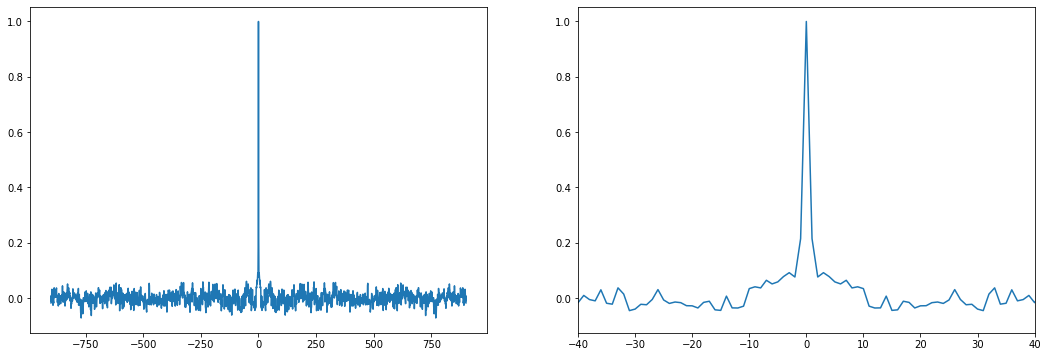

In [10]:
autocorr_lags_flut = np.arange(-1*(len(_autocorr_dict['FLUT']) // 2),len(_autocorr_dict['FLUT']) // 2+1)

flut_autocorr_fig,flut_autocorr_axs = plt.subplots(1,2,figsize=(18,6))
flut_autocorr_axs[0].plot(autocorr_lags_flut,_autocorr_dict['FLUT'])

flut_autocorr_axs[1].plot(autocorr_lags_flut,_autocorr_dict['FLUT'])
flut_autocorr_axs[1].set_xlim(-40,40)

In [11]:
_autocorr_dict['TS'].sum()

0.6754109001640098

(-40.0, 40.0)

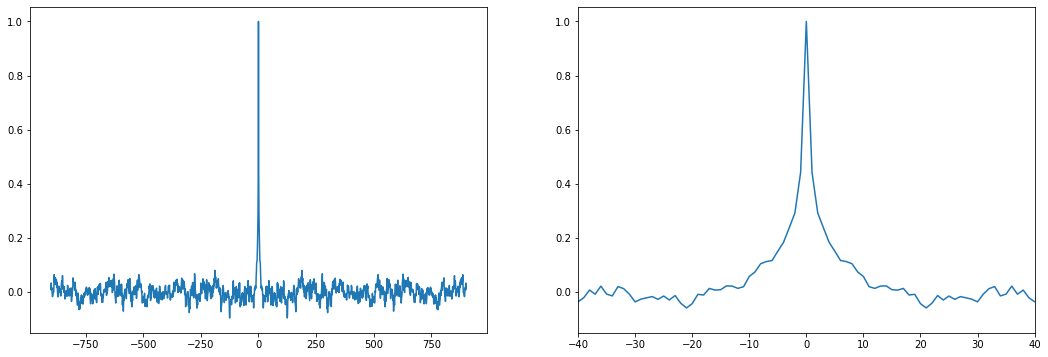

In [12]:
autocorr_lags_ts = np.arange(-1*(len(_autocorr_dict['TS']) // 2),len(_autocorr_dict['TS']) // 2+1)

ts_autocorr_fig,ts_autocorr_axs = plt.subplots(1,2,figsize=(18,6))
ts_autocorr_axs[0].plot(autocorr_lags_ts,_autocorr_dict['TS'])

ts_autocorr_axs[1].plot(autocorr_lags_ts,_autocorr_dict['TS'])
ts_autocorr_axs[1].set_xlim(-40,40)

##### Calculate $\tau_{var}$

The Leroy paper notes that significant autocorrelation is unlikely to occur for lags greater than a few years, motivating us to truncate the autocorrelation at some lag where noise starts to dominate. We need to have a method to do this however. Since the "noise" is not actually centered about zero, I'll sum over the autocorrelation function and pick tau as the maximum value. This might lead to tau values slightly enhanced by noise, and is perhaps conservative, but I think it's probably the safest strategy.

In [13]:
def calc_tauvar(autocorrelation_data,max_lag=100,verbose=True):
    ''' 
    The Leroy paper notes that significant autocorrelation is unlikely to occur for lags greater than a few years, 
    motivating us to truncate the autocorrelation at some lag where noise starts to dominate. We need to have a method 
    to do this however. Since the "noise" is not actually centered about zero, I'll sum over the autocorrelation 
    function and pick tau as the maximum value. This might lead to tau values slightly enhanced by noise, and is 
    perhaps conservative, but I think it's probably the safest strategy.
    '''
    
    midpoint = len(autocorrelation_data)//2 # index for the midpoint of the autocorrelation data
    
    try:
        np.testing.assert_almost_equal(autocorrelation_data[midpoint],1,decimal=5) # This point should be 1 if the autocorrelation is formatted correctly and normalized
    except:
        print("Midpoint of 'autocorrelation_data' is not 1. Check that data is symmetric and normalized.")
        return
    
    tau_summer = [] # array containing tau as a function of lags considered
    lags = [] # array containing the lags tested (reference)

    for lag in range(1,max_lag+1): # iterate over possible lags

        pointsabout = autocorrelation_data[midpoint-lag:midpoint+1+lag] # get all points within the lag for the autocorrelation function
        test_tau = np.sum(pointsabout) 

        tau_summer.append(test_tau)
        lags.append(lag)
    
    max_tau = np.max(tau_summer)
    
    if verbose:
        print('Maximum Tau of %.2f found at lag %d.' % (max_tau,lags[np.argmax(tau_summer)]))
    
    return max_tau

The values I get from this method are <10% greater than values I found when arbitrarily generating cutoff lags, so I think that this method is reasonable and conservative.

Now, calculate $\tau_{var}$ for our variables.

In [14]:
_tauvar_dict = {}

for _var in ens_vars:
    
    _tauvar_dict[_var] = calc_tauvar(_autocorr_dict[_var],verbose=False)

In [15]:
_tauvar_dict

{'FLUT': 2.4907143475617675,
 'TS': 4.722961458304506,
 'ICEFRAC': 5.796937088191588,
 'TMQ': 2.5465758553483795,
 'FSNTOA': 3.338208130057043}

These results indicate more memory in surface temperature than OLR. Alone this would have the effect of making the effective number of surface temperature measurements fewer, thus delaying detection. But we also have to consider the natural variability term.

Compute the Leroy time-to-detection values.

In [16]:
# compute delta-t, the time-to-detection from Leroy et al. (2008)
# $$ \Delta t = \left[ \frac{12s^2}{m_{est}^2} \sigma_{var}^2 \tau_{var} \right]^{1/3}, $$

deltaT_dict = {}

s = 2 # SNR is two (two standard deviations gives a 95% confidence interval)

for _var in ens_vars:
    
    # Grab the stored values for the appropriate variable
    _slope  = _regress_dict[_var][0]
    _stddev = _sigmaN_dict[_var]
    _tauvar = _tauvar_dict[_var]
    
    _deltaT = (12*s**2 * _stddev**2 * _tauvar / _slope**2)**(1/3) # time calculated using a correlation time from the summing method    
    
    deltaT_dict[_var] = _deltaT    

__Leroy time-to-detection values:__

In [17]:
deltaT_dict

{'FLUT': <xarray.DataArray 'FLUT' ()>
 array(21.35153202),
 'TS': <xarray.DataArray 'TS' ()>
 array(18.27381001),
 'ICEFRAC': <xarray.DataArray 'ICEFRAC' ()>
 array(15.91834463),
 'TMQ': <xarray.DataArray 'TMQ' ()>
 array(13.85200451),
 'FSNTOA': <xarray.DataArray 'FSNTOA' ()>
 array(17.77837962)}

These values are much longer than those predicted by the Weatherhead method, which is confusing because I think they are identical besides using lag-1 autocorrelation vs. sum of the autocorrelation to look at data redness. Again, we see that with perfect observations, it takes about 3 years longer to detect a change in Arctic annual OLR than TS. This is longer, but not by a factor of two.

#### Naive LENS-based time-to-detection method

Here, I intend to produce time-to-detection estimates using the output from the CESM1 and CESM2 Large Ensemble datasets that are somewhat analogous to the signal-to-noise methods employed previously. These methods define time-to-detection as when the mean forced response exceeds the natural climate variability at 95% confidence. I can do the same by creating a 95% confidence intervals (~2 std. devs. to be comparable with Weatherhead and Leroy) and comparing them to a linear trend calculated from the large ensemble forced response. Importantly, I am __not__ calculating a 95% confidence interval on the "true" unforced trend. We know that the unforced trend is zero. We want to know a range of trends that 95% of unforced models fall into, which represents a reasonable range of internal variability. 

I expect these results to be similar to those estimated from the Leroy method.

I will robustly calculate the 95% confidence interval for observational durations of 2 to 50 years using bootstrapping. "Naive detection" will occur when the climate signal from the forced response lies outside of this confidence interval.

Calculate a 95% confidence interval on unforced trends in our climate signals for observation durations from 2 to 50 years.

In [18]:
def pi_tseries_to_ens(pic_var_dict,tlength,nmembers,verbose=True):
    '''
    This function takes a long control run and returns N (nmembers) non-overlapping members of length tlength (years).
    If the long control run does not have enough time for this, the function returns as many members as fit in.
    '''
    
    month_increment = tlength*12 # length of the timeseries

    pic_final_dict = {}
    for _var in pic_var_dict: # iterate over keys, which are the variables
        if verbose:
            print(_var)

        pic_tseries_dict = {}

        for mem_n in range(nmembers):
            # Define index start and endpoints
            start_index = mem_n*month_increment
            end_index = start_index + month_increment

            if end_index > len(pic_var_dict[_var].time):
                print('Cannot fit %d non-overlapping ensemble members of %d years in the available data. Returning %d members.' % (nmembers,tlength,mem_n))
                break
            sub_tseries = pic_var_dict[_var].isel(time=slice(start_index,end_index))

            # print(sub_tseries.time) # test code demonstrates non-overlapping t-series

            # create a fake timeseries so that we can combine these fake ensemble members
            # timeseries must be between print(pd.Timestamp.min) and print(pd.Timestamp.max) 1677 and 2262 roughly. I am just starting mine at 1700 so they are obviously PI
            new_times = pd.date_range('1700/01/01',freq='1M',periods=month_increment,closed=None) 
            new_times_da = xr.DataArray(new_times, [('time', new_times)]) # turn into an xarray object
            sub_tseries_timefixed = sub_tseries.assign_coords({'time':new_times_da})

            sub_tseries_timefixed['ens'] = mem_n # add ensemble coordinate for easy combining

            pic_tseries_dict[str(mem_n)] = sub_tseries_timefixed

        pic_all_tseries = xr.concat(list(pic_tseries_dict.values()),dim='ens')

        pic_final_dict[_var] = pic_all_tseries
    
    return pic_final_dict

Compute slopes on unforced slopes for observation durations between 2 and 50 years.

In [19]:
min_dur = 2
max_dur = 50
min_duration = 2
max_duration = 50

durations = np.arange(min_duration,max_duration+1)

In [20]:
nmembers=40
# pic_slopes_dict_yr_var = {} # the most outside indexer is the variable (var) and the inner indexer is the year (yr)
test_dict = {}

for _var in ens_vars: # iterate over variables of interest
    _var_pic_tseries = cesm1_pic_ds[[_var]] # pi_tseries_to_ens operates on an xr.dataset, so I use double brackets

    lens_slopes_dict = {}
    for _dur in range(min_dur,max_dur+1): # iterate over possible detection durations
        
        members_of_dur = pi_tseries_to_ens(_var_pic_tseries,tlength=_dur,nmembers=nmembers,verbose=False) # aim for 40 members (same as the CESM1-LENS)
        members_of_dur_annavgs = members_of_dur[_var].groupby('time.year').mean() # compute an annual mean

        _lens_polyfit = members_of_dur_annavgs.polyfit(dim='year',deg=1) # take a linear fit
        _lens_slopes = _lens_polyfit['polyfit_coefficients'].sel(degree=1).values # pull out the slope from the linear fit

        # pad with nans out to the desired number of members, will need to remember this later
        padding = np.nan*np.zeros(nmembers - len(_lens_slopes))
        _lens_slopes_padded = np.concatenate((_lens_slopes,padding),axis=0)
        
        lens_slopes_dict[_dur] = _lens_slopes_padded # save slopes in an inner dictionary
    
    # shift the data to an xarray object so future operations do not require iteration
    _temp_da = xr.DataArray(
        data=np.stack(list(lens_slopes_dict.values()),axis=1),
        dims=["ens", "duration"],
        coords=dict(
            ens=(np.arange(1,nmembers+1)),
            duration=(durations),
        ),
        name = _var
    )
    test_dict[_var] = _temp_da
    del lens_slopes_dict
    # pic_slopes_dict_yr_var[_var] = lens_slopes_dict    

pic_slopes_dur_ds = xr.merge(test_dict.values())

del test_dict

Cannot fit 40 non-overlapping ensemble members of 46 years in the available data. Returning 39 members.
Cannot fit 40 non-overlapping ensemble members of 47 years in the available data. Returning 38 members.
Cannot fit 40 non-overlapping ensemble members of 48 years in the available data. Returning 37 members.
Cannot fit 40 non-overlapping ensemble members of 49 years in the available data. Returning 36 members.
Cannot fit 40 non-overlapping ensemble members of 50 years in the available data. Returning 36 members.
Cannot fit 40 non-overlapping ensemble members of 46 years in the available data. Returning 39 members.
Cannot fit 40 non-overlapping ensemble members of 47 years in the available data. Returning 38 members.
Cannot fit 40 non-overlapping ensemble members of 48 years in the available data. Returning 37 members.
Cannot fit 40 non-overlapping ensemble members of 49 years in the available data. Returning 36 members.
Cannot fit 40 non-overlapping ensemble members of 50 years in th

Compute 95% confidence intervals on unforced slopes for observation durations between 2 and 50 years.

The methods produce similar results, but bootstrapping takes a bit longer. The issue here is that we're not interested in a 95% confidence interval on the mean slope. We know that the mean slope is zero. We interested in a slope that exceeds 95% of the models. This is actually easier, as we can just bootstrap the 95th percentile. So I'll repeat and just bootstrap the 5th and 9th percentiles.

In [21]:
def bootstrap_percentiles(varname,slope_ds,durations,alpha,nbootstraps=2000):
    '''
    Function to bootstrap 5th and 95th percentiles on slopes for different durations,
    and return the result in an xarray format.
    Assumes that it will be passed a xr.dataset object and list of durations.
    '''
    
    _bounds_dict_bstrap_dur = {} # empty dictionary to store objects in
        
    for _dur in durations:
        # select slopes for a given duration and variable, drop nans
        _slopes     = slope_ds[varname].sel(duration=_dur).dropna(dim='ens') 
        N_ens       = len(_slopes) # number of members

        # Compute percentiles using bootstrapping
        lower_percentile = []
        upper_percentile = []
        for i in range(1,nbootstraps): # bootstrap, calculating percentiles
            resample_slopes = np.random.choice(_slopes, N_ens, replace=True) # resample with replacement
            lower_percentile.append(np.percentile(resample_slopes,100*(alpha/2)))
            upper_percentile.append(np.percentile(resample_slopes,100*(1-alpha/2)))
        
        _lower_bnd_bstrap = np.mean(lower_percentile) # take the mean percentile
        _upper_bnd_bstrap = np.mean(upper_percentile)
        
        _bounds_dict_bstrap_dur[_dur] = [_lower_bnd_bstrap,_upper_bnd_bstrap] # save in the dictionary
        
    # save output in an xarray format for easy future usage
    _bounds_da = xr.DataArray(
        data=np.stack(list(_bounds_dict_bstrap_dur.values()),axis=1),
        dims=["bound", "duration"],
        coords=dict(
            bound=[0,1], # 0 is the lower bound (5th perc.) and 1 is the upper bound (95th perc.)
            duration=(durations),
        ),
        name = varname
    )
    
    del _bounds_dict_bstrap_dur # clean up
    
    return _bounds_da

In [22]:
# bootstrapping precentiles approach
confidence_int = 95
alpha = 1 - 0.01*confidence_int
# print('alpha ',alpha)

perc_dict_bstrap_dur_var = {}
_temp_dict = {}

for _var in ens_vars:
    
    _temp_dict[_var] = bootstrap_percentiles(varname=_var,slope_ds=pic_slopes_dur_ds,alpha=alpha,durations=durations)
    
pic_bounds_dur_ds = xr.merge(_temp_dict.values()) # combine into xarray so indexing is straightforward

Now when will the forced trend be outside of this confidence interval?

In [23]:
# Do for bootstrapped 5th and 95th percentiles of the unforced response and the stationary forced response slope (m_est).
detect_naivest_dict = {}

for _var in ens_vars:
    
    # Grab the stored values for the appropriate variable
    _slope  = _regress_dict[_var][0]
    
    _lower_bounds = pic_bounds_dur_ds[_var].sel(bound=0)
    _upper_bounds = pic_bounds_dur_ds[_var].sel(bound=1)
    
    detect_bool = np.bitwise_or(_slope < _lower_bounds, _slope > _upper_bounds)
    
    detect_naivest_dict[_var] = detect_bool

Now I just need to interpret these arrays correctly to give the number of years that naive detection will take. Since there is some noise, we may see detection then no detection and then detection. A robust result would be when all subsequent durations qualify as a detection (i.e. it wouldn't make sense to say you could detect after 15 years if you can't detect after 16 years, best to skip to 17). So I will pick the first year after the last "non-detectable" duration.

Naively calculate the "emergence" year, assuming a stationary forced response.

In [24]:
# This is the naivest because we ignore the state-dependence of the forced response
emergence_naivest_dict = {}

for _var in ens_vars:
    
    # _durations = np.array(list(perc_dict_bstrap_dur_var[_var].keys()))
    
    _nodetect_indices = np.argwhere(~np.array(detect_naivest_dict[_var])) # get the indices 
    
    _last_nodetect = np.max(_nodetect_indices)
    _first_detect  = _last_nodetect + 1
    
    detect_duration = durations[_first_detect]
    
    print('Naive detection of annual %s emergence after %d years.' % (_var,detect_duration))
    
    emergence_naivest_dict[_var] = detect_duration

Naive detection of annual FLUT emergence after 20 years.
Naive detection of annual TS emergence after 14 years.
Naive detection of annual ICEFRAC emergence after 9 years.
Naive detection of annual TMQ emergence after 12 years.
Naive detection of annual FSNTOA emergence after 18 years.


Correctly using percentiles, the naive ensemble-based approach says that it should take 18 years to detect OLR changes and 14 years to detect TS changes (i.e 50% chance of the measured trend being outside the 95th percentile from a LENS). Interestingly, this falls between the Leroy and Weatherhead values.

#### Nuanced Large-Ensemble Method (simplified Barnhart)

Here, I intend to produce time-to-detection estimates using the output from the CESM1 and CESM2 Large Ensemble datasets that account for variability in the forced response. Whereas previous methods treat the forced response as a single value (the mean forced response), here I will place confidence intervals on the forced response to answer a more useful question: "How many years do we need to measure to be 95% confident of measuring a "detectable" trend? (one that exceeds 95% natural climate variability)"

I expect these results to predict longer detection times than the previous three methods employed.

Now I just need to generate percentiles for the forced response and compare those lower bounds with the 95th percentiles of internal variability.

In [25]:
test_dict = {}

for _var in ens_vars:    
    ens_tseries = cesm1_ensresponse_ds[_var] # select your variable
    
    ens_tseries_ann = ens_tseries.groupby('time.year').mean('time') # turn into annual tseries
    
    lens_slopes_dict = {}
    for _dur in durations: # iterate over possible detection durations 
        tseries_dur_subset = ens_tseries_ann.isel(year=slice(None,_dur)) # subset in time
        
        _lens_polyfit = tseries_dur_subset.polyfit(dim='year',deg=1) # take a linear fit
        _lens_slopes = _lens_polyfit['polyfit_coefficients'].sel(degree=1).values # pull out the slope from the linear fit
        
        lens_slopes_dict[_dur] = _lens_slopes # save slopes in an inner dictionary
        
    # shift the data to an xarray object so future operations do not require iteration
    _temp_da = xr.DataArray(
        data=np.stack(list(lens_slopes_dict.values()),axis=1),
        dims=["ens", "duration"],
        coords=dict(
            ens=(np.arange(1,nmembers+1)),
            duration=(durations),
        ),
        name = _var
    )
    test_dict[_var] = _temp_da
    del lens_slopes_dict
                
lens_slopes_dur_ds = xr.merge(test_dict.values())

Bootstrap percentiles on the forced response trend for our different durations.

In [26]:
def bootstrap_percentiles2(varname,slope_ds,durations,alpha,nbootstraps=2000):
    '''
    Function to bootstrap 5th and 95th percentiles AND the mean(!!) on slopes for different durations,
    and return the result in an xarray format.
    Assumes that it will be passed a xr.dataset object and list of durations.
    '''
    
    _bounds_dict_bstrap_dur = {} # empty dictionary to store objects in
        
    for _dur in durations:
        # select slopes for a given duration and variable, drop nans
        _slopes     = slope_ds[varname].sel(duration=_dur).dropna(dim='ens') 
        N_ens       = len(_slopes) # number of members

        # Compute percentiles using bootstrapping
        lower_percentile = []
        upper_percentile = []
        mean_slope = []
        
        for i in range(1,nbootstraps): # bootstrap, calculating percentiles
            resample_slopes = np.random.choice(_slopes, N_ens, replace=True) # resample with replacement
            lower_percentile.append(np.percentile(resample_slopes,100*(alpha/2)))
            upper_percentile.append(np.percentile(resample_slopes,100*(1-alpha/2)))
            mean_slope.append(np.median(resample_slopes))
        
        _lower_bnd_bstrap  = np.mean(lower_percentile) # take the mean percentile
        _upper_bnd_bstrap  = np.mean(upper_percentile)
        _mean_slope_bstrap = np.mean(mean_slope)
        
        _bounds_dict_bstrap_dur[_dur] = [_lower_bnd_bstrap,_upper_bnd_bstrap,_mean_slope_bstrap] # save in the dictionary
                
    # save output in an xarray format for easy future usage
    _bounds_da = xr.DataArray(
        data=np.stack(list(_bounds_dict_bstrap_dur.values()),axis=1),
        dims=["bound", "duration"],
        coords=dict(
            bound=[0,1,2], # 0 is the lower bound (5th perc.) and 1 is the upper bound (95th perc.)
            duration=(durations),
        ),
        name = varname
    )
    
    del _bounds_dict_bstrap_dur # clean up
    
    return _bounds_da

In [27]:
# bootstrapping precentiles approach
confidence_int = 95
alpha = 1 - 0.01*confidence_int
# print('alpha ',alpha)

perc_dict_bstrap_dur_var = {}
_temp_dict = {}

for _var in ens_vars:
    
    _temp_dict[_var] = bootstrap_percentiles2(varname=_var,slope_ds=lens_slopes_dur_ds,alpha=alpha,durations=durations)
    
lens_bounds_dur_ds = xr.merge(_temp_dict.values()) # combine into xarray so indexing is straightforward

__Calculate detection comparing the evolving mean forced response of the model and confidence intervals from the pre-industrial simulations__

In [28]:
# Do for bootstrapped 5th and 95th percentiles of the unforced response and the stationary forced response slope (m_est).
detect_naive_dict = {}

for _var in ens_vars:
    
    # Grab the stored values for the appropriate variable
    _mean_slopes_forced = lens_bounds_dur_ds[_var].sel(bound=2) # use the mean value of the forced response, but let it vary as a function of the duration
    
    _lower_bounds = pic_bounds_dur_ds[_var].sel(bound=0)
    _upper_bounds = pic_bounds_dur_ds[_var].sel(bound=1)
    
    # If the forced response lies outside of the Pre-industrial range, detection occurs
    detect_bool = np.bitwise_or(_mean_slopes_forced < _lower_bounds, _mean_slopes_forced > _upper_bounds)
    
    detect_naive_dict[_var] = detect_bool

Naively calculate the "emergence" year, now assuming an evolving forced response.

In [29]:
# This is the naivest because we ignore the state-dependence of the forced response
emergence_naive_dict = {}

for _var in ens_vars:    
    _nodetect_indices = np.argwhere(~np.array(detect_naive_dict[_var])) # get the indices 
    
    _last_nodetect = np.max(_nodetect_indices)
    _first_detect  = _last_nodetect + 1
    
    detect_duration = durations[_first_detect]
    
    print('Naive detection of annual %s emergence after %d years.' % (_var,detect_duration))
    
    emergence_naive_dict[_var] = detect_duration

Naive detection of annual FLUT emergence after 20 years.
Naive detection of annual TS emergence after 20 years.
Naive detection of annual ICEFRAC emergence after 20 years.
Naive detection of annual TMQ emergence after 18 years.
Naive detection of annual FSNTOA emergence after 18 years.


__Calculate detection comparing confidence intervals of the evolving forced response of the model and confidence intervals from the pre-industrial simulations__

Now when will the forced trend be outside of this confidence interval?

In [30]:
# Do for bootstrapped 5th and 95th percentiles and the .
detect_complex_dict = {}

for _var in ens_vars:
    
    # Grab the 90% range (5-95 cdf) on the forced response
    _lower_bounds_forced = lens_bounds_dur_ds[_var].sel(bound=0)
    _upper_bounds_forced = lens_bounds_dur_ds[_var].sel(bound=1)

    # Grab the 5th and 95 percentiles of the pre-industrial control
    _lower_bounds_pic = pic_bounds_dur_ds[_var].sel(bound=0)
    _upper_bounds_pic = pic_bounds_dur_ds[_var].sel(bound=1)
    
    # Boolean to tell us if these intervals are non-overlapping
    detect_bool = np.bitwise_or(_lower_bounds_forced > _upper_bounds_pic, _lower_bounds_pic > _upper_bounds_forced)
    
    detect_complex_dict[_var] = detect_bool

In [31]:
emergence_complex_dict = {}

for _var in ens_vars:
        
    _nodetect_indices = np.argwhere(~np.array(detect_complex_dict[_var])) # get the indices 
    
    _last_nodetect = np.max(_nodetect_indices)
    _first_detect  = _last_nodetect + 1
    
    detect_duration = durations[_first_detect]
    
    print('Complex detection of annual %s emergence after %d years.' % (_var,detect_duration))
    emergence_complex_dict[_var] = detect_duration
    
    # break

Complex detection of annual FLUT emergence after 31 years.
Complex detection of annual TS emergence after 27 years.
Complex detection of annual ICEFRAC emergence after 27 years.
Complex detection of annual TMQ emergence after 22 years.
Complex detection of annual FSNTOA emergence after 27 years.


I'm surprised that the delay between TS and OLR detection hasn't gotten larger. But wow the time to detection is much much longer. Nearly a factor of 2 and definitely more than a decade.

## Visualize the different methods of calculating time-to-detection

In [32]:
# Dictionary holding the full names for plotting purposes
ens_varnames = {
    'FLUT'   : 'Outgoing Longwave Radiation',
    'TS'     : 'Surface Temperature',
    'ICEFRAC': 'Sea Ice Fraction',
    'TMQ'    : 'Total Column Water',
    'FSNTOA' : 'Absorbed Shortwave Radiation',  # Net solar flux at top of atmosphere
}

In [33]:
# Dictionary holding the full names for plotting purposes
ens_varunits = {
    'FLUT'   : 'Wm$^{-2}$',
    'TS'     : 'deg. C',
    'ICEFRAC': 'fraction',
    'TMQ'    : 'kgm$^{-2}$',
    'FSNTOA' : 'Wm$^{-2}$',  # Net solar flux at top of atmosphere
}

In [34]:
def plot_detection(var_name,var_fullname,var_units,ylims=None):
    
    det_fig1,det_ax1 = plt.subplots(1,1,figsize=(12,12))

    # Grab the 5th and 95 percentiles of the pre-industrial control
    _lower_bounds_pic = pic_bounds_dur_ds[var_name].sel(bound=0)
    _upper_bounds_pic = pic_bounds_dur_ds[var_name].sel(bound=1)

    # Grab the 5th and 95 percentiles of the RCP8.5-forced ensemble runs
    _lower_bounds_forced = lens_bounds_dur_ds[var_name].sel(bound=0)
    _upper_bounds_forced = lens_bounds_dur_ds[var_name].sel(bound=1)
    _mean_slopes_forced  = lens_bounds_dur_ds[var_name].sel(bound=2)
    
    det_ax1.hlines(_regress_dict[var_name][0],2,50,color='red',label='Mean Forced Response (m$_{est}$)',linewidth=1) # plot the mean forced response
    det_ax1.plot(durations,_mean_slopes_forced,color='red',label='Evolving forced response')

    # Plot confidence bounds on the forced and unforced slopes
    det_ax1.fill_between(x=durations,y1=_lower_bounds_pic,y2=_upper_bounds_pic,label='CESM1-LE PI-Control (95% confidence interval)',color='blue',alpha=0.3)
    det_ax1.fill_between(x=durations,y1=_lower_bounds_forced,y2=_upper_bounds_forced,label='CESM1-LE RCP8.5 (90% confidence interval)',color='red',alpha=0.3)

    # Plot markers for different types of detection
    det_ax1.scatter(emergence_naivest_dict[var_name],_regress_dict[var_name][0],marker='s',s=100,color='None',edgecolors='black',
                    label='Emergence of a climate signal assuming stationary forced response. (%s years)' % emergence_naivest_dict[var_name])

    det_ax1.scatter(emergence_naive_dict[var_name],_mean_slopes_forced[emergence_naive_dict[var_name]-1],marker='o',s=100,color='None',edgecolors='black',
                    label='Emergence of a climate signal at 50%% confidence. (%s years)' % emergence_naive_dict[var_name])

    # check which side of the distributions to put the complex detection marker on
    if _lower_bounds_forced[emergence_complex_dict[var_name]] > _upper_bounds_pic[emergence_complex_dict[var_name]]:
        det_ax1.scatter(emergence_complex_dict[var_name],_lower_bounds_forced[emergence_complex_dict[var_name]-1],marker='*',s=150,color='None',edgecolors='black',
                        label='Emergence of a climate signal at 95%% confidence. (%s years)' % emergence_complex_dict[var_name])
    else:
        det_ax1.scatter(emergence_complex_dict[var_name],_upper_bounds_forced[emergence_complex_dict[var_name]-1],marker='*',s=150,color='None',edgecolors='black',
                        label='Emergence of a climate signal at 95%% confidence. (%s years)' % emergence_complex_dict[var_name])
        
    det_ax1.vlines(deltaT_dict[var_name],*det_ax1.get_ylim(),color='black',linewidth=1,
                   label='Time-to-detection from Leroy et al. 2008 (%.2f years)' % deltaT_dict[var_name])

    det_ax1.vlines(nstar_dict[var_name],*det_ax1.get_ylim(),color='black',linewidth=1,linestyle='dashed',
                   label='Time-to-detection from Weatherhead et al. 1998 (%.2f years)' % nstar_dict[var_name])

    det_ax1.set_xlabel('Duration of Observations (yrs)',fontsize=20)
    det_ax1.set_ylabel('%s Trend (%s yr$^{-1}$)' % (var_fullname,var_units),fontsize=20)

    if not type(ylims) is type(None):
        det_ax1.set_ylim(*ylims)
    else: 
        ylow  = np.min(np.concatenate([_lower_bounds_pic,_lower_bounds_forced]))
        yhigh = np.max(np.concatenate([_upper_bounds_pic,_upper_bounds_forced]))
        det_ax1.set_ylim(ylow,yhigh)
    det_ax1.legend()
    
    det_ax1.tick_params(labelsize=20)
    
    return det_fig1

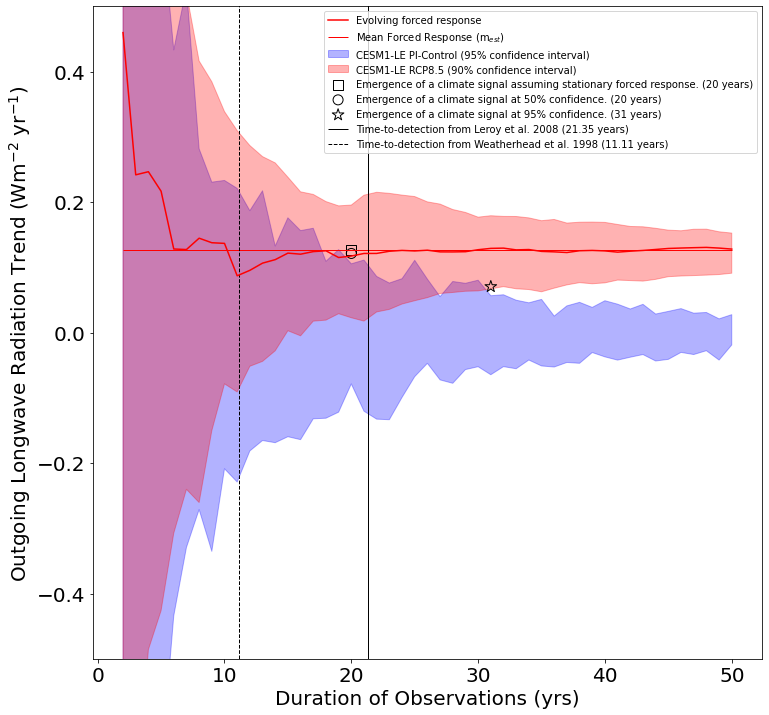

In [35]:
_var = 'FLUT'

flut_emergenceplot = plot_detection(_var,ens_varnames[_var],ens_varunits[_var],ylims=[-0.5,0.5])

In [36]:
# to_png(flut_emergenceplot,'OLR_emergenceplot',dpi=300)

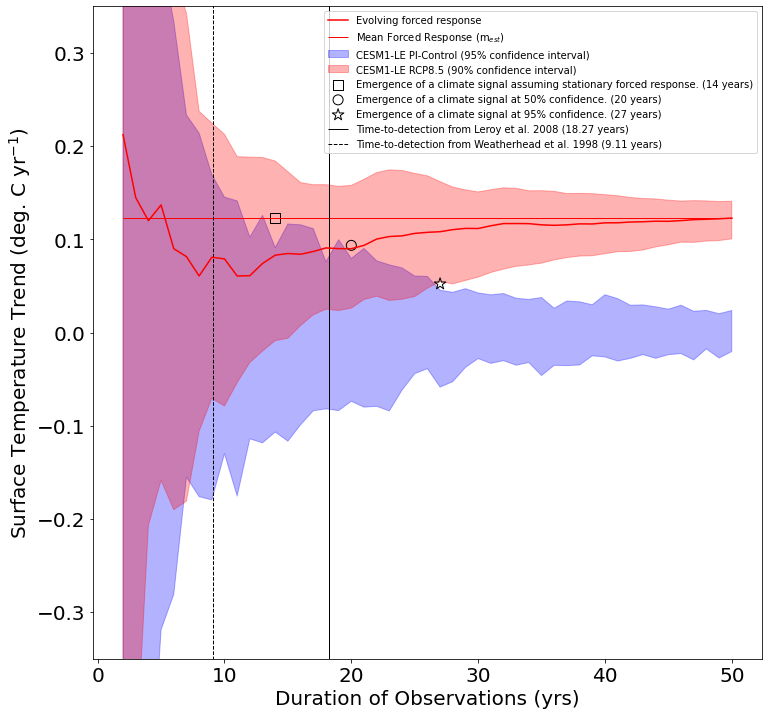

In [37]:
_var = 'TS'

ts_emergenceplot = plot_detection(_var,ens_varnames[_var],ens_varunits[_var],ylims=[-0.35,0.35])

In [38]:
# to_png(ts_emergenceplot,'TS_emergenceplot',dpi=300)